In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow
import eli5
import shap
from eli5.sklearn import PermutationImportance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_curve, auc
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
# Load the dataset
file_path = "C:/Users/Ayush/Downloads/Smart Energy Management System/household_power_consumption.txt"
data = pd.read_csv(file_path, sep=";", low_memory=False, on_bad_lines='skip')

In [9]:
# Data Preprocessing
# Replace missing values (marked with "?") with NaN
data.replace("?", np.nan, inplace=True)

# Drop rows with missing values
data.dropna(inplace=True)

# Convert columns to numeric
data["Global_active_power"] = pd.to_numeric(data["Global_active_power"])

# Combine Date and Time columns into a single DateTime column
data["DateTime"] = pd.to_datetime(data["Date"] + " " + data["Time"], format='%d/%m/%Y %H:%M:%S', errors='coerce')

# Drop rows with invalid DateTime values (NaT)
data.dropna(subset=['DateTime'], inplace=True)

# Sort data by DateTime
data.sort_values("DateTime", inplace=True)

# Select the target variable: Global_active_power
target = data["Global_active_power"].values

In [10]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target.reshape(-1, 1))

# Prepare the dataset for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Set time step (e.g., 50 timesteps to predict the next value)
time_step = 50
X, y = create_dataset(target_scaled, time_step)

# Reshape input to be [samples, time steps, features] for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

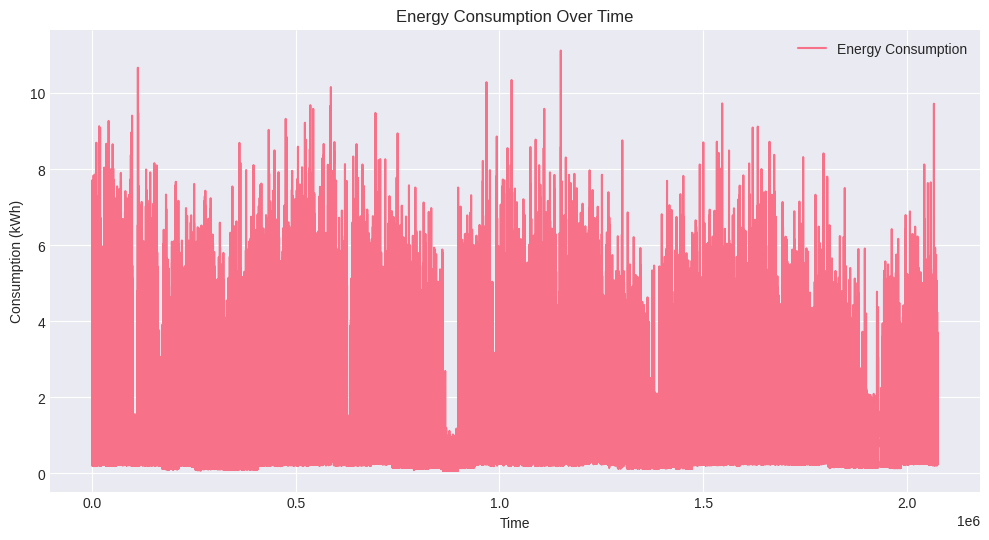

In [16]:
# Line Plot for Energy Consumption Over Time

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Global_active_power'], label='Energy Consumption')
plt.title('Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.show()

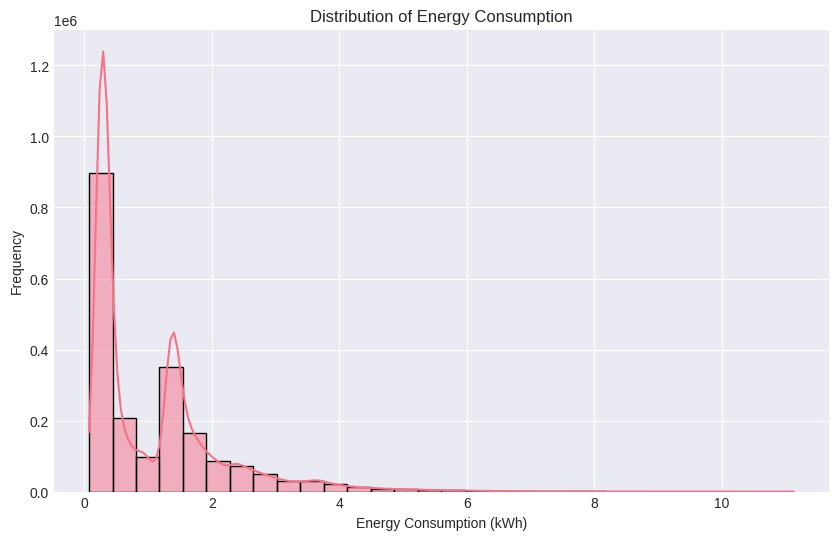

In [18]:
# Histogram of Energy Consumption Distribution

plt.figure(figsize=(10, 6))
sns.histplot(data['Global_active_power'], kde=True, bins=30)
plt.title('Distribution of Energy Consumption')
plt.xlabel('Energy Consumption (kWh)')
plt.ylabel('Frequency')
plt.show()

In [27]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 477s 9ms/step - loss: 6.7967e-04 - val_loss: 4.0598e-04
Epoch 2/10
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 509s 9ms/step - loss: 5.9218e-04 - val_loss: 3.8447e-04
Epoch 3/10
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 499s 9ms/step - loss: 5.6544e-04 - val_loss: 3.7551e-04
Epoch 4/10
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 507s 9ms/step - loss: 5.4191e-04 - val_loss: 3.5573e-04
Epoch 5/10
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 495s 9ms/step - loss: 5.1949e-04 - val_loss: 3.5908e-04
Epoch 6/10
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 478s 9ms/step - loss: 5.0863e-04 - val_loss: 3.4022e-04
Epoch 7/10
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 483s 9ms/step - loss: 4.9899e-04 - val_loss: 3.4168e-04
Epoch 8/10
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 504s 9ms/step - loss: 4.8948e-04 - val_loss: 3.3200e-04
Epoch 9/10
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 504s 9ms/step - loss: 4.8373e-04 - val_loss: 3.3487e-04
Epoch 10/10
51231/51231 ━━━━━━━━━━━━━━━━━━━━ 476s 9ms/step - loss: 4.7911e-04 - val_loss: 3.2840e-04

51231/51231 ━━━━━━━━━━━━━━━━━━━━ 143s 3ms/step
12808/12808 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step


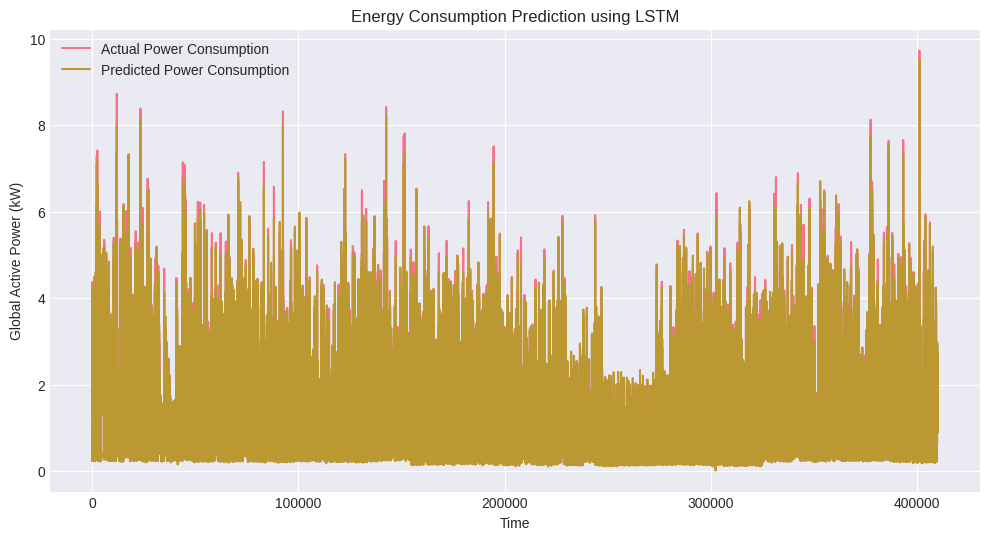

In [30]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Inverse transform the actual values to original scale
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Power Consumption")
plt.plot(test_predict, label="Predicted Power Consumption")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kW)")
plt.title("Energy Consumption Prediction using LSTM")
plt.legend()
plt.show()

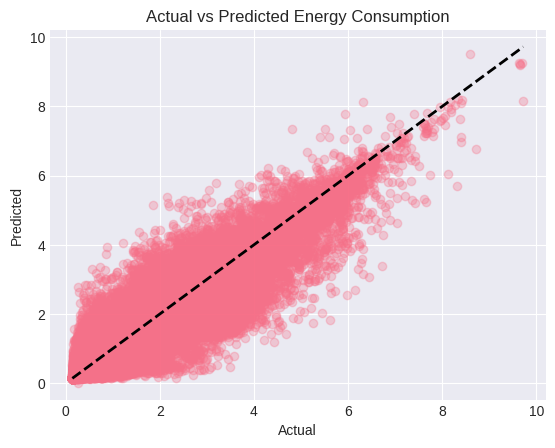

In [32]:
# Actual vs Predicted Values Plot

plt.scatter(y_test_actual, test_predict, alpha=0.3)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Energy Consumption')
plt.show()

In [39]:
# Define thresholds for classification
def classify_energy_consumption(value):
    if value < 1:
        return 0  # Low
    elif 1 <= value < 3:
        return 1  # Medium
    else:
        return 2  # High

# Classify actual and predicted values
y_test_actual_class = np.array([classify_energy_consumption(val) for val in y_test_actual.flatten()])
test_predict_class = np.array([classify_energy_consumption(val) for val in test_predict.flatten()])

In [40]:
# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test_actual_class, test_predict_class)
precision = precision_score(y_test_actual_class, test_predict_class, average="weighted")
recall = recall_score(y_test_actual_class, test_predict_class, average="weighted")

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9690
Precision: 0.9689
Recall: 0.9690


In [ ]:
import joblib

# Save the trained Random Forest model
joblib.dump(model, "occupancy_model.h5")
print("✅ Occupancy model saved as occupancy_model.h5")
